In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
import keras

In [3]:
from libtiff import TIFF3D,TIFF
train = TIFF3D.open("/Users/mac/Desktop/MLCookbook/datasets/train-volume.tif").read_image().reshape(-1,512,512,1)
label = TIFF3D.open("/Users/mac/Desktop/MLCookbook/datasets/train-labels.tif").read_image().reshape(-1,512,512,1)
test = TIFF3D.open("/Users/mac/Desktop/MLCookbook/datasets/test-volume.tif").read_image().reshape(-1,512,512,1)

# U-NET模型

In [4]:
input_shape = (512, 512, 1)
inputs = Input(input_shape)

conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
    UpSampling2D(size=(2, 2))(drop5))
merge6 = merge([drop4, up6], mode='concat', concat_axis=3)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)


up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
    UpSampling2D(size=(2, 2))(conv6))
merge7 = merge([conv3, up7], mode='concat', concat_axis=3)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
    UpSampling2D(size=(2, 2))(conv7))
merge8 = merge([conv2, up8], mode='concat', concat_axis=3)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
    UpSampling2D(size=(2, 2))(conv8))
merge9 = merge([conv1, up9], mode='concat', concat_axis=3)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

model = Model(input=inputs, output=conv10)

model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

keras.utils.vis_utils.plot_model(model, to_file="U-NET.png")

# 生成训练数据

In [5]:
datagen = ImageDataGenerator(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

In [6]:
from itertools import cycle
def train_label_gen(train, label, batch_size):
    merged_train_label = np.concatenate((train, label, label), axis=-1)
    while True:
        gen_train_label = datagen.flow(merged_train_label, batch_size=batch_size).next()
#         print gen_train_label[:,:,:,0].shape, gen_train_label[:,:,:,1].shape
        yield gen_train_label[:,:,:,0].reshape(batch_size, 512, 512, 1), gen_train_label[:,:,:,1].reshape(batch_size, 512, 512, 1)

In [7]:
batch_size = 1
epochs = 1
steps_per_epoch = 1

In [8]:
model.fit_generator(
    train_label_gen(train, label, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
#     validation_data=train_label_gen(train, label, batch_size=batch_size),
#     validation_steps=30,
    epochs=epochs, verbose=1
)

Epoch 1/1
1/1 [==============================] - 34s - loss: 2910.7012 - acc: 0.2488


In [9]:
# model.fit(train, label, batch_size=1, nb_epoch=10, verbose=1, shuffle=True)

In [10]:
model.save_weights("u-net.h5")

In [11]:
result = model.predict(test[:2], batch_size=1, verbose=1)

2/2 [==============================] - 14s    


In [12]:
result = result.reshape(2,512,512)

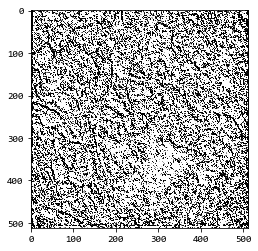

In [13]:
plt.imshow(result[0], cmap='gray')